In [1]:
import astropy.coordinates as coord
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt

%matplotlib inline
import numpy as np

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

import sys

if "../scripts" not in sys.path:
    sys.path.append("../scripts")
from streamsubhalosim import (
    get_in_stream_frame,
    StreamSubhaloSimulation,
    get_stream_track,
    get_new_basis,
    get_subhalo_w0,
)
from streamsubhaloplot import plot_sky_projections

In [2]:
# mw = gp.load('/Users/apricewhelan/projects/gaia-actions/potentials/MilkyWayPotential2022.yml')
mw = gp.NFWPotential.from_circular_velocity(220*u.km/u.s, 15*u.kpc, units=galactic)

In [38]:
dist = 20.
pos = [-8+20, 0, 0] * u.kpc
vcirc = mw.circular_velocity(pos)[0]
wf = gd.PhaseSpacePosition(pos=pos, vel=[0, 1.3, 0] * vcirc)

In [228]:
sim = StreamSubhaloSimulation(
    mw_potential=mw,
    final_prog_w=wf,
    M_stream=5e4 * u.Msun,
    t_post_impact=0 * u.Myr,
    t_pre_impact=6 * u.Gyr,
    dt=0.5 * u.Myr,
    n_particles=2,
    seed=42,
)

In [229]:
init_stream, init_prog = sim.run_init_stream()
impact_site = sim.get_impact_site(init_stream, init_prog)

In [230]:
R = get_new_basis(
    impact_site.xyz.value,
    impact_site.v_xyz.value
)

In [231]:
# make subhalo orbit from impact site - dx and dz, but with impact parameter b
b = 250 * u.pc
subhalo_w0 = get_subhalo_w0(
    impact_site, b=b, phi=90 * u.deg, vphi=100 * u.km / u.s, vz=0 * u.km / u.s
)

o1 = mw.integrate_orbit(subhalo_w0, dt=-0.1 * u.Myr, t1=0, t2=-50 * u.Myr)
o2 = mw.integrate_orbit(subhalo_w0, dt=0.1 * u.Myr, t1=0, t2=50 * u.Myr)
o1 = o1[::-1]
o2 = o2[1:]

subhalo_orbit = gd.Orbit(
    np.hstack((o1.xyz, o2.xyz)),
    np.hstack((o1.v_xyz, o2.v_xyz)),
    t=np.concatenate((o1.t, o2.t)),
    frame=o1.frame
)

In [232]:
frame = gp.ConstantRotatingFrame(
    [0, 0, 1]
    * impact_site.cylindrical.pm_phi.to(u.km / u.s / u.kpc, u.dimensionless_angles()), 
    units=galactic
)

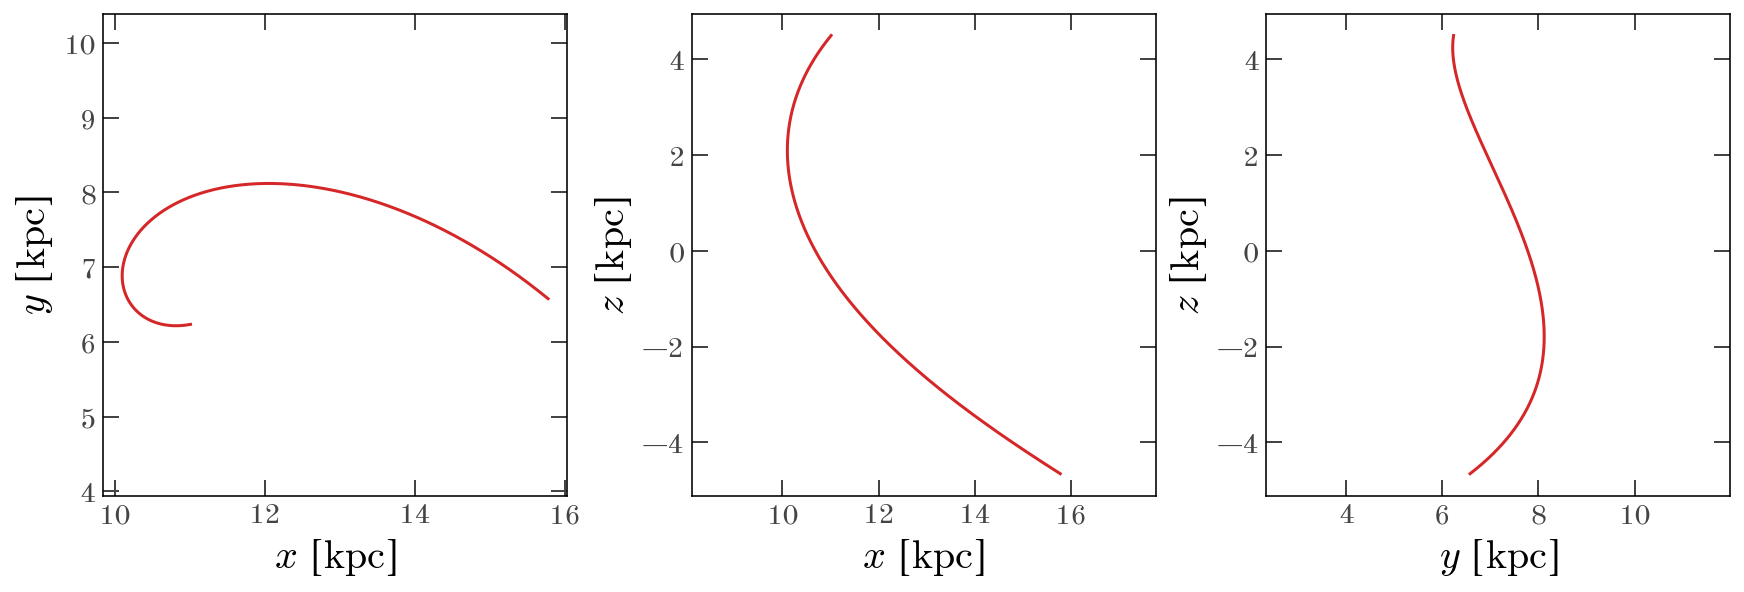

In [233]:
subhalo_orbit.to_frame(frame).plot(color='tab:red');

In [234]:
_dx = subhalo_orbit.xyz.T - impact_site.xyz.T
i = np.linalg.norm(_dx, axis=1).argmin()
assert np.abs(subhalo_orbit.t[i]) < 1*u.Myr
_dx[i]

<Quantity [2.32249522e-01, 9.25211291e-02, 1.35860240e-05] kpc>

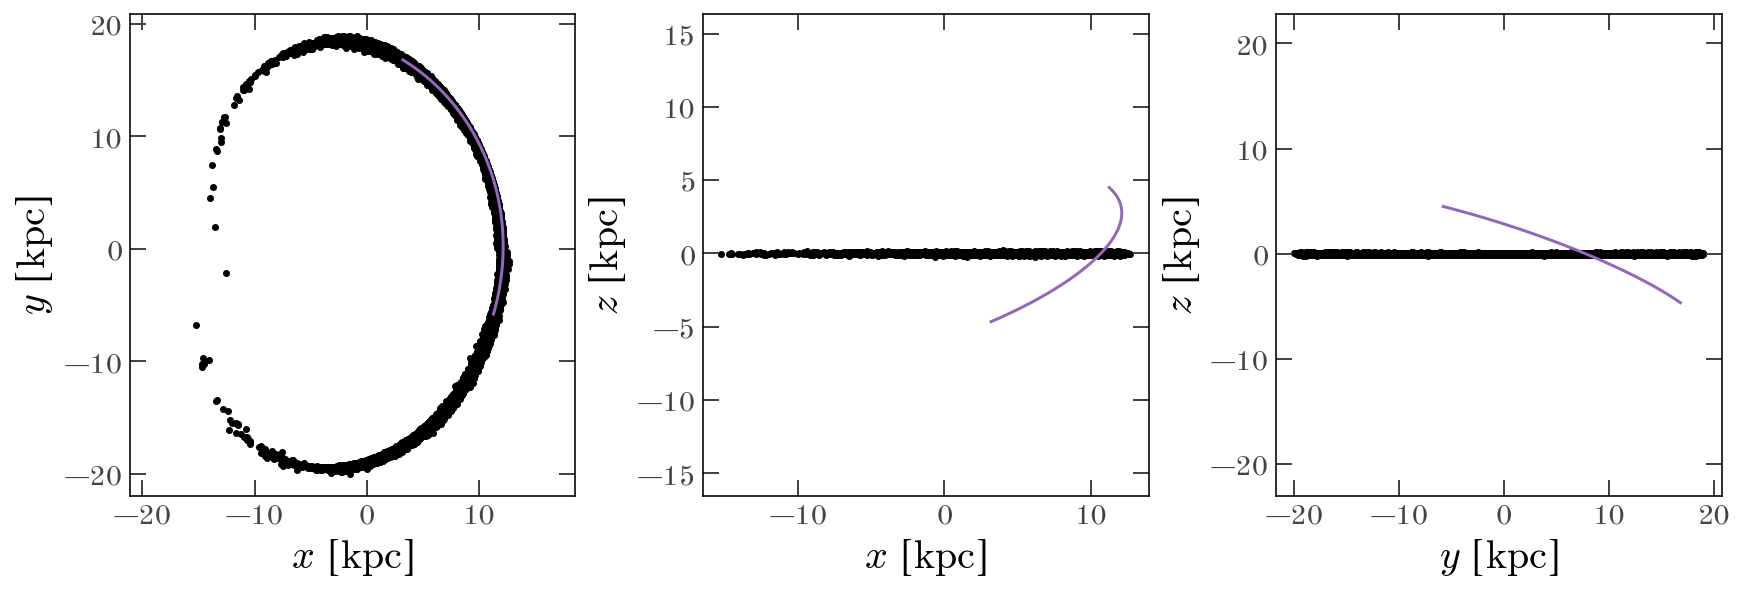

In [235]:
fig = init_stream.plot();
subhalo_orbit.plot(axes=fig.axes, color='tab:purple');

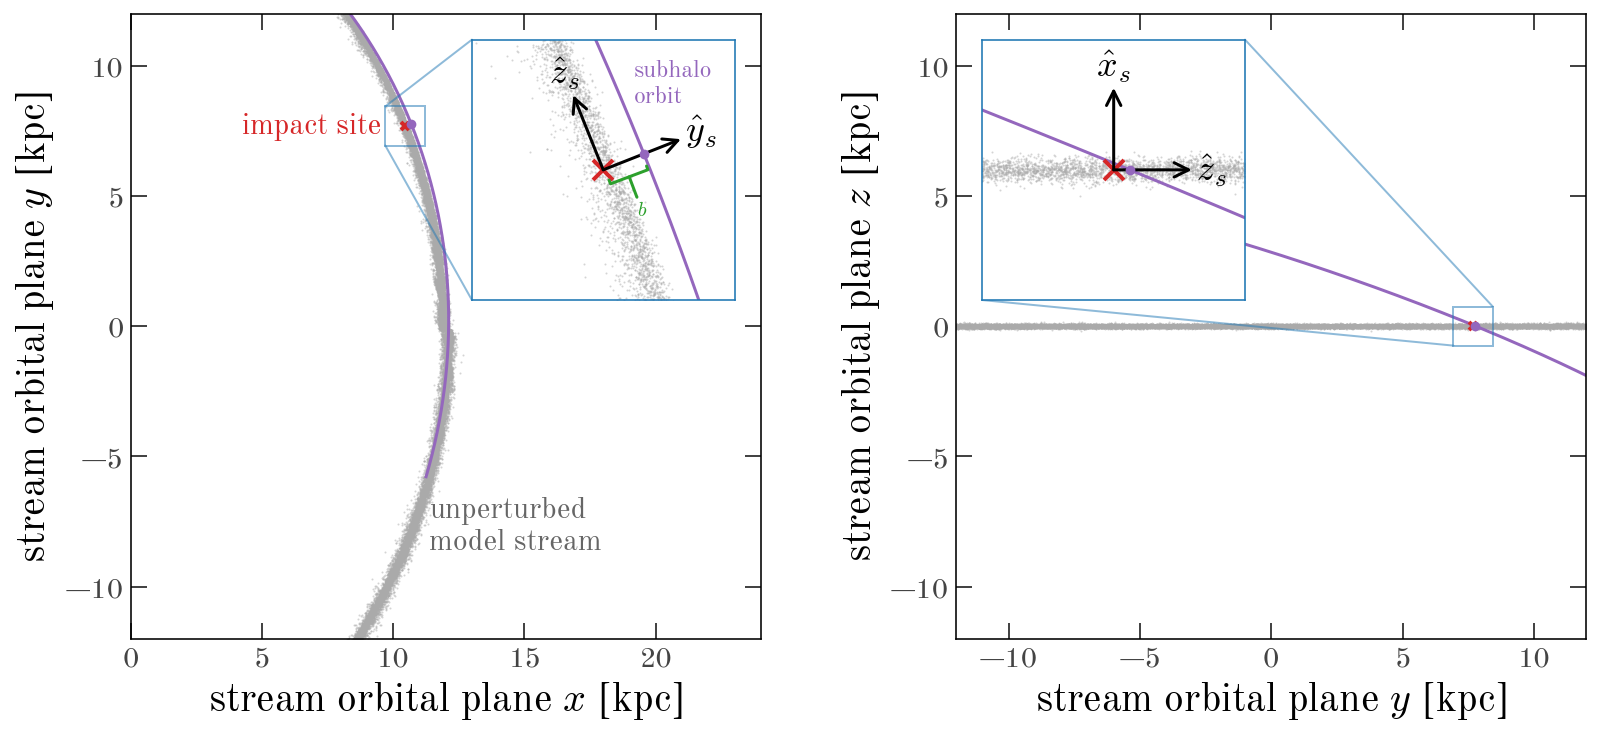

In [237]:
stream_style = dict(
    marker="o",
    linestyle="none",
    mew=0,
    alpha=0.5,
    ms=1,
    color="#aaaaaa",
    rasterized=True,
)
basis_style = dict(
    ha="center",
    va="center",
    arrowprops=dict(arrowstyle="<-", lw=1.5, color="k", shrinkA=0, shrinkB=0),
    fontsize=18,
    zorder=100,
)
subhalo_orbit_style = dict(
    color="tab:purple", autolim=False, auto_aspect=False, labels=None
)
subhalo_style = dict(
    marker="o",
    s=15,
    color="tab:purple",
    autolim=False,
    auto_aspect=False,
    zorder=200,
    units=u.kpc,
    labels=None,
)

fig, axes = plt.subplots(1, 2, figsize=(11, 5), constrained_layout=True)

x0 = impact_site.x.to_value(u.kpc)
y0 = impact_site.y.to_value(u.kpc)
z0 = impact_site.z.to_value(u.kpc)
h = 0.75
xhat, yhat, zhat = R.T * 0.6

# ---
axes[0].set(
    xlim=(0, 24),
    ylim=(-12, 12),
    xlabel="stream orbital plane $x$ [kpc]",
    ylabel="stream orbital plane $y$ [kpc]",
)

axins = axes[0].inset_axes([13, 1, 10, 10], transform=axes[0].transData, zorder=100)
axins.set(xlim=(x0 - h, x0 + h), ylim=(y0 - h, y0 + h))
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
axes[0].indicate_inset_zoom(axins, edgecolor="tab:blue")
for k, sp in axins.spines.items():
    sp.set_color("tab:blue")

for ax, ms in zip([axes[0], axins], [4, 10]):
    ax.plot(
        init_stream.x.to_value(u.kpc), init_stream.y.to_value(u.kpc), **stream_style
    )
    ax.plot(x0, y0, marker="x", ms=ms, mew=2, zorder=50, color="tab:red")
    subhalo_orbit.plot(["x", "y"], axes=[ax], **subhalo_orbit_style)
    subhalo_w0.plot(["x", "y"], axes=[ax], **subhalo_style)

ax = axins
ax.annotate(r"$\hat{y}_s$", (x0, y0), (x0 + yhat[0], y0 + yhat[1]), **basis_style)
ax.annotate(r"$\hat{z}_s$", (x0, y0), (x0 + zhat[0], y0 + zhat[1]), **basis_style)

axes[0].text(
    x0 - 1.2 * h,
    y0,
    "impact site",
    ha="right",
    va="center",
    fontsize=15,
    color="tab:red",
)
axes[0].text(
    x0 + 1.2 * h,
    -y0,
    "unperturbed\nmodel stream",
    ha="left",
    va="center",
    fontsize=15,
    color="#666666",
)
axins.text(
    x0 + 0.7 * b.to_value(u.kpc),  #  + 1.2 * h,
    y0 + 2 * b.to_value(u.kpc),
    "subhalo\norbit",
    ha="left",
    va="center",
    fontsize=12,
    color="tab:purple",
)

tmp = (R @ (np.array([0, 0.5, 0]) * b)).to_value(u.kpc)
ang = -(90 * u.deg - np.arctan2(tmp[1], tmp[0]) * u.rad) - 3 * u.deg
offset = 1.3 * b.to_value(u.kpc) * np.array([np.cos(ang), np.sin(ang)])
axins.annotate(
    "$b$",
    (x0 + tmp[0], y0 + tmp[1]),
    (x0 + tmp[0] + offset[0], y0 + tmp[1] + offset[1]),
    arrowprops=dict(arrowstyle="-[", lw=1.5, color="tab:green", shrinkA=0, shrinkB=8),
    zorder=1000,
    color="tab:green",
    ha="center",
)

# ---

axes[1].set(
    xlim=(-12, 12),
    ylim=(-12, 12),
    xlabel="stream orbital plane $y$ [kpc]",
    ylabel="stream orbital plane $z$ [kpc]",
)

axins = axes[1].inset_axes([-11, 1, 10, 10], transform=axes[1].transData, zorder=100)
axins.set(xlim=(y0 - h, y0 + h), ylim=(z0 - h, z0 + h))
axins.xaxis.set_visible(False)
axins.yaxis.set_visible(False)
axes[1].indicate_inset_zoom(axins, edgecolor="tab:blue")
for k, sp in axins.spines.items():
    sp.set_color("tab:blue")

for ax, ms in zip([axes[1], axins], [4, 10]):
    ax.plot(
        init_stream.y.to_value(u.kpc), init_stream.z.to_value(u.kpc), **stream_style
    )
    ax.plot(y0, z0, marker="x", ms=ms, mew=2, color="tab:red", zorder=50)
    subhalo_orbit.plot(["y", "z"], axes=[ax], **subhalo_orbit_style)
    subhalo_w0.plot(["y", "z"], axes=[ax], **subhalo_style)

ax = axins
ax.annotate(r"$\hat{z}_s$", (y0, z0), (y0 + zhat[1], z0 + zhat[2]), **basis_style)
ax.annotate(r"$\hat{x}_s$", (y0, z0), (y0 + xhat[1], z0 + xhat[2]), **basis_style)

fig.get_layout_engine().set(hspace=0.0, wspace=0.1)

fig.savefig("../tex/figures/schematic.pdf", dpi=200)

---

In [72]:
stream_sfr = get_in_stream_frame(init_stream, impact=impact_site, prog=init_prog[0])
tracks = get_stream_track(stream_sfr, lon_lim=(-45, 45))

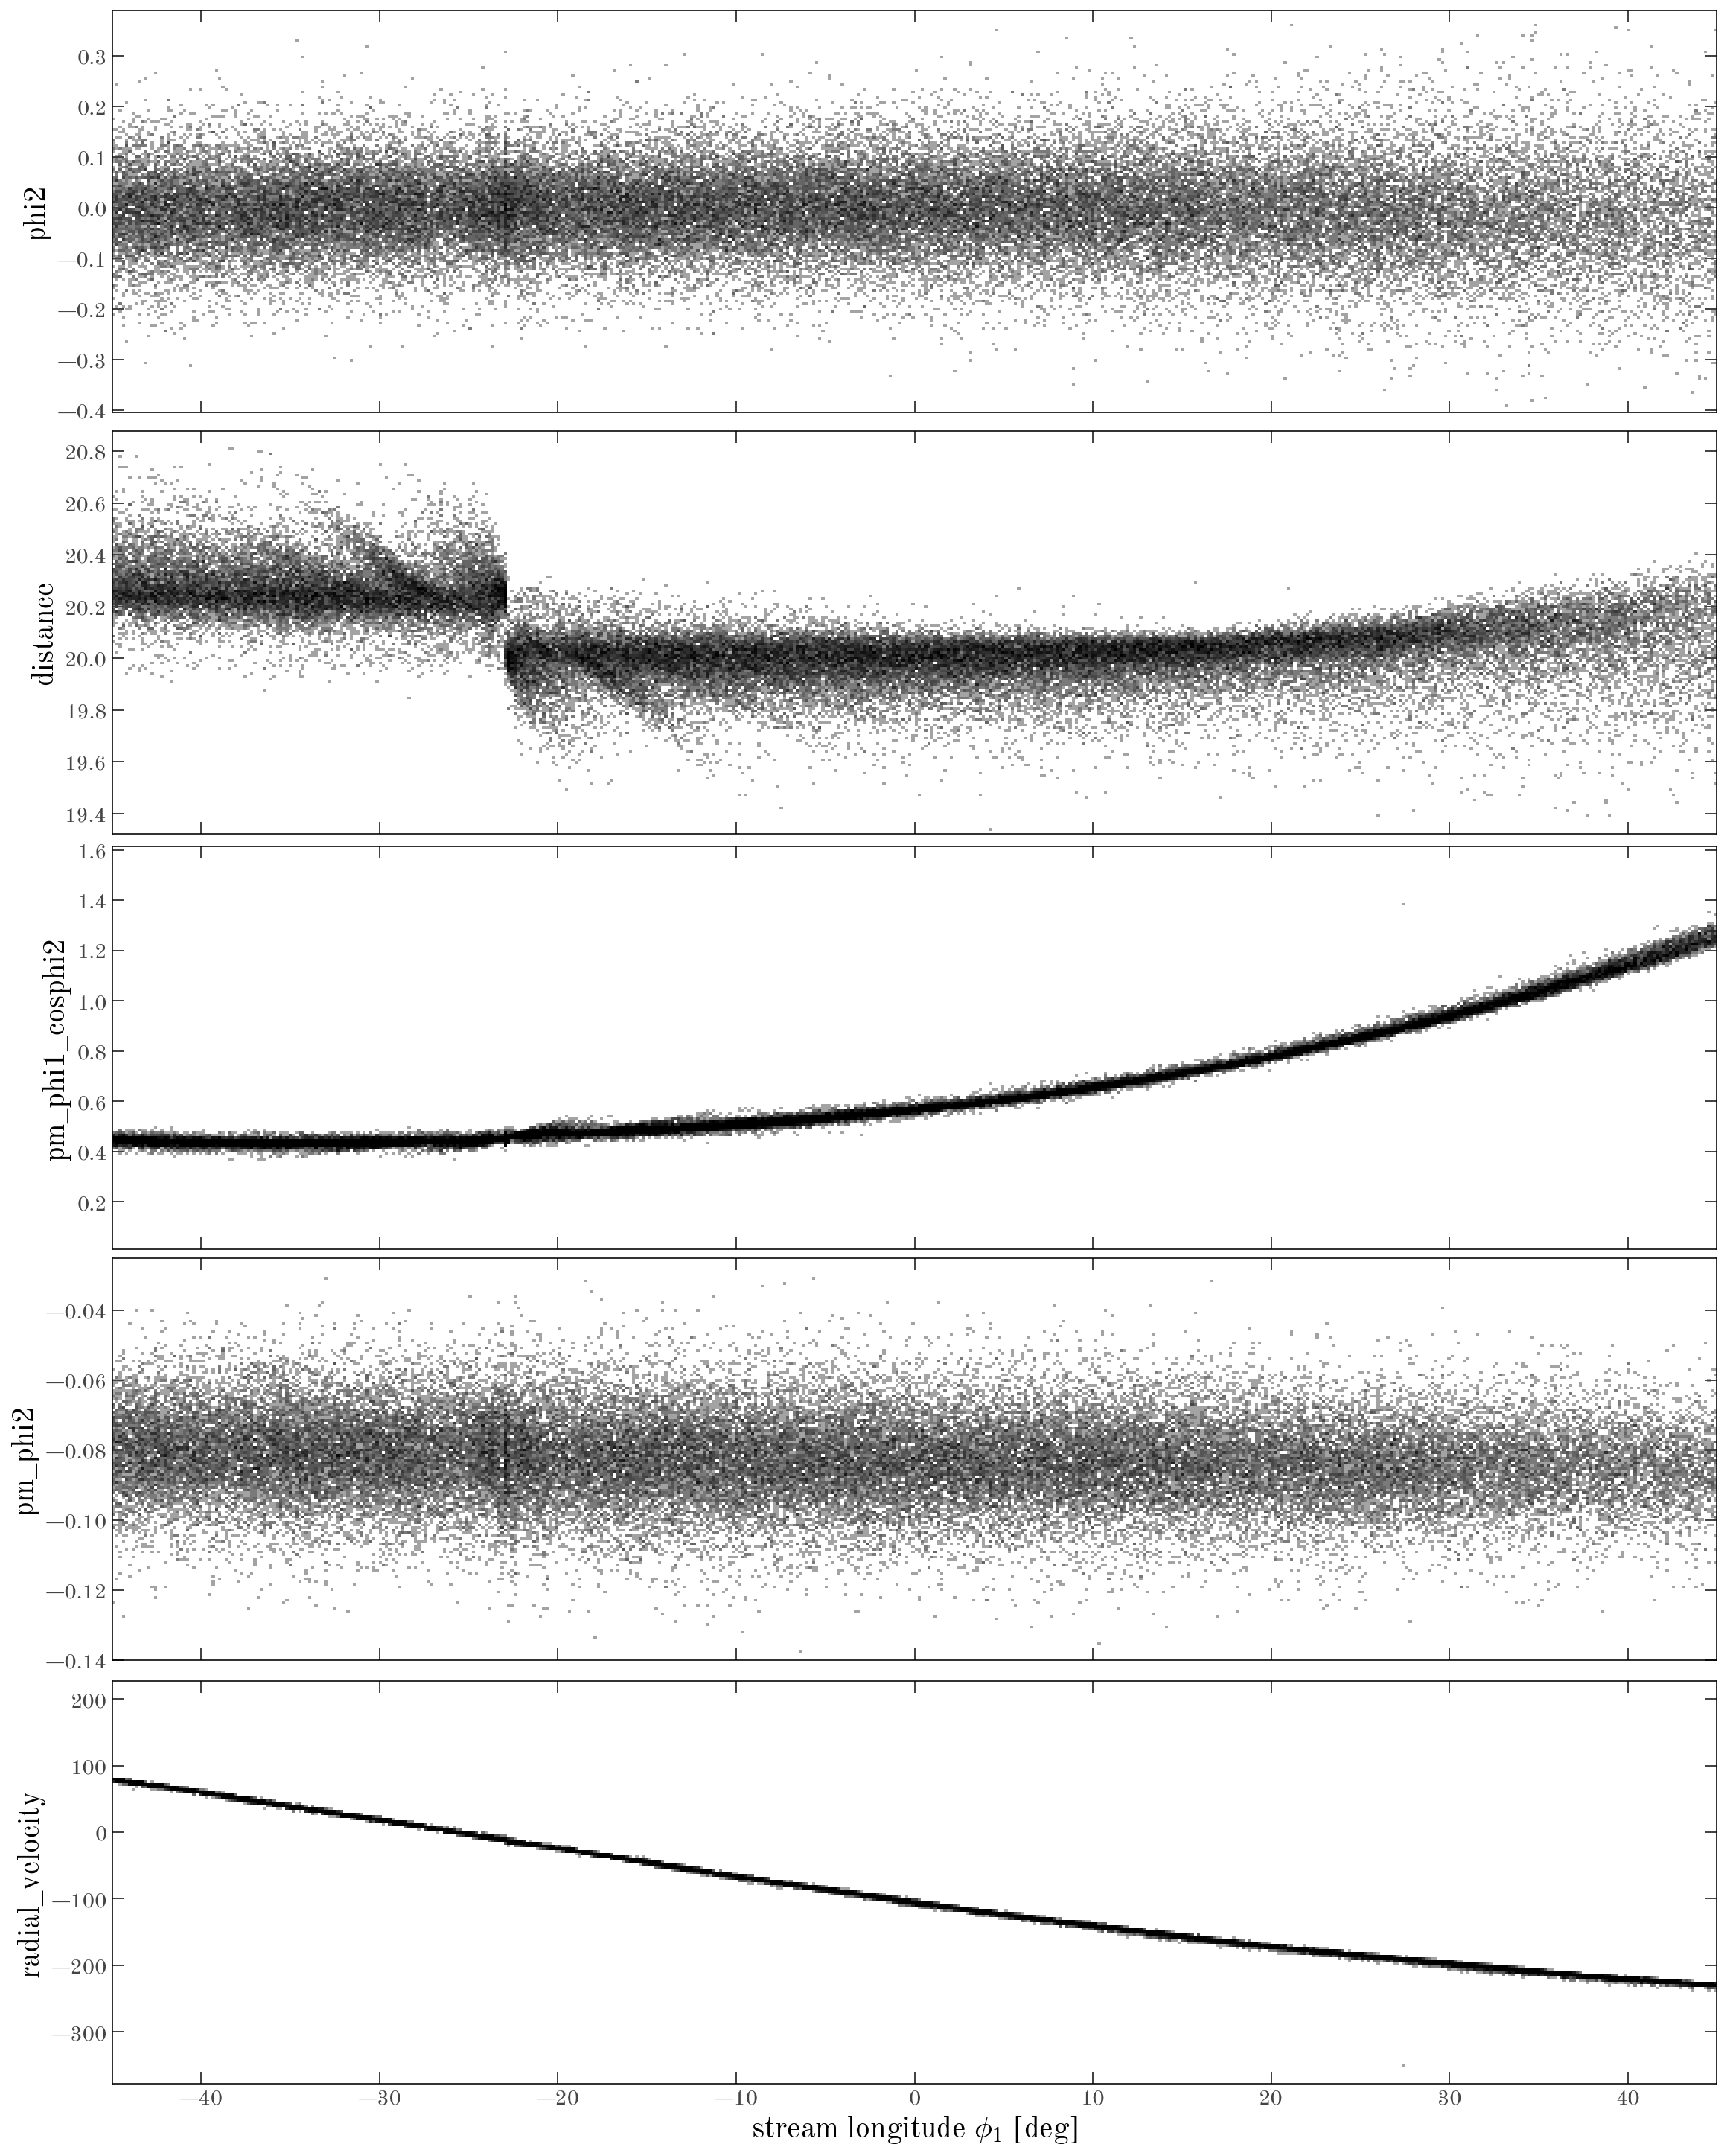

In [28]:
plot_sky_projections(stream_sfr);

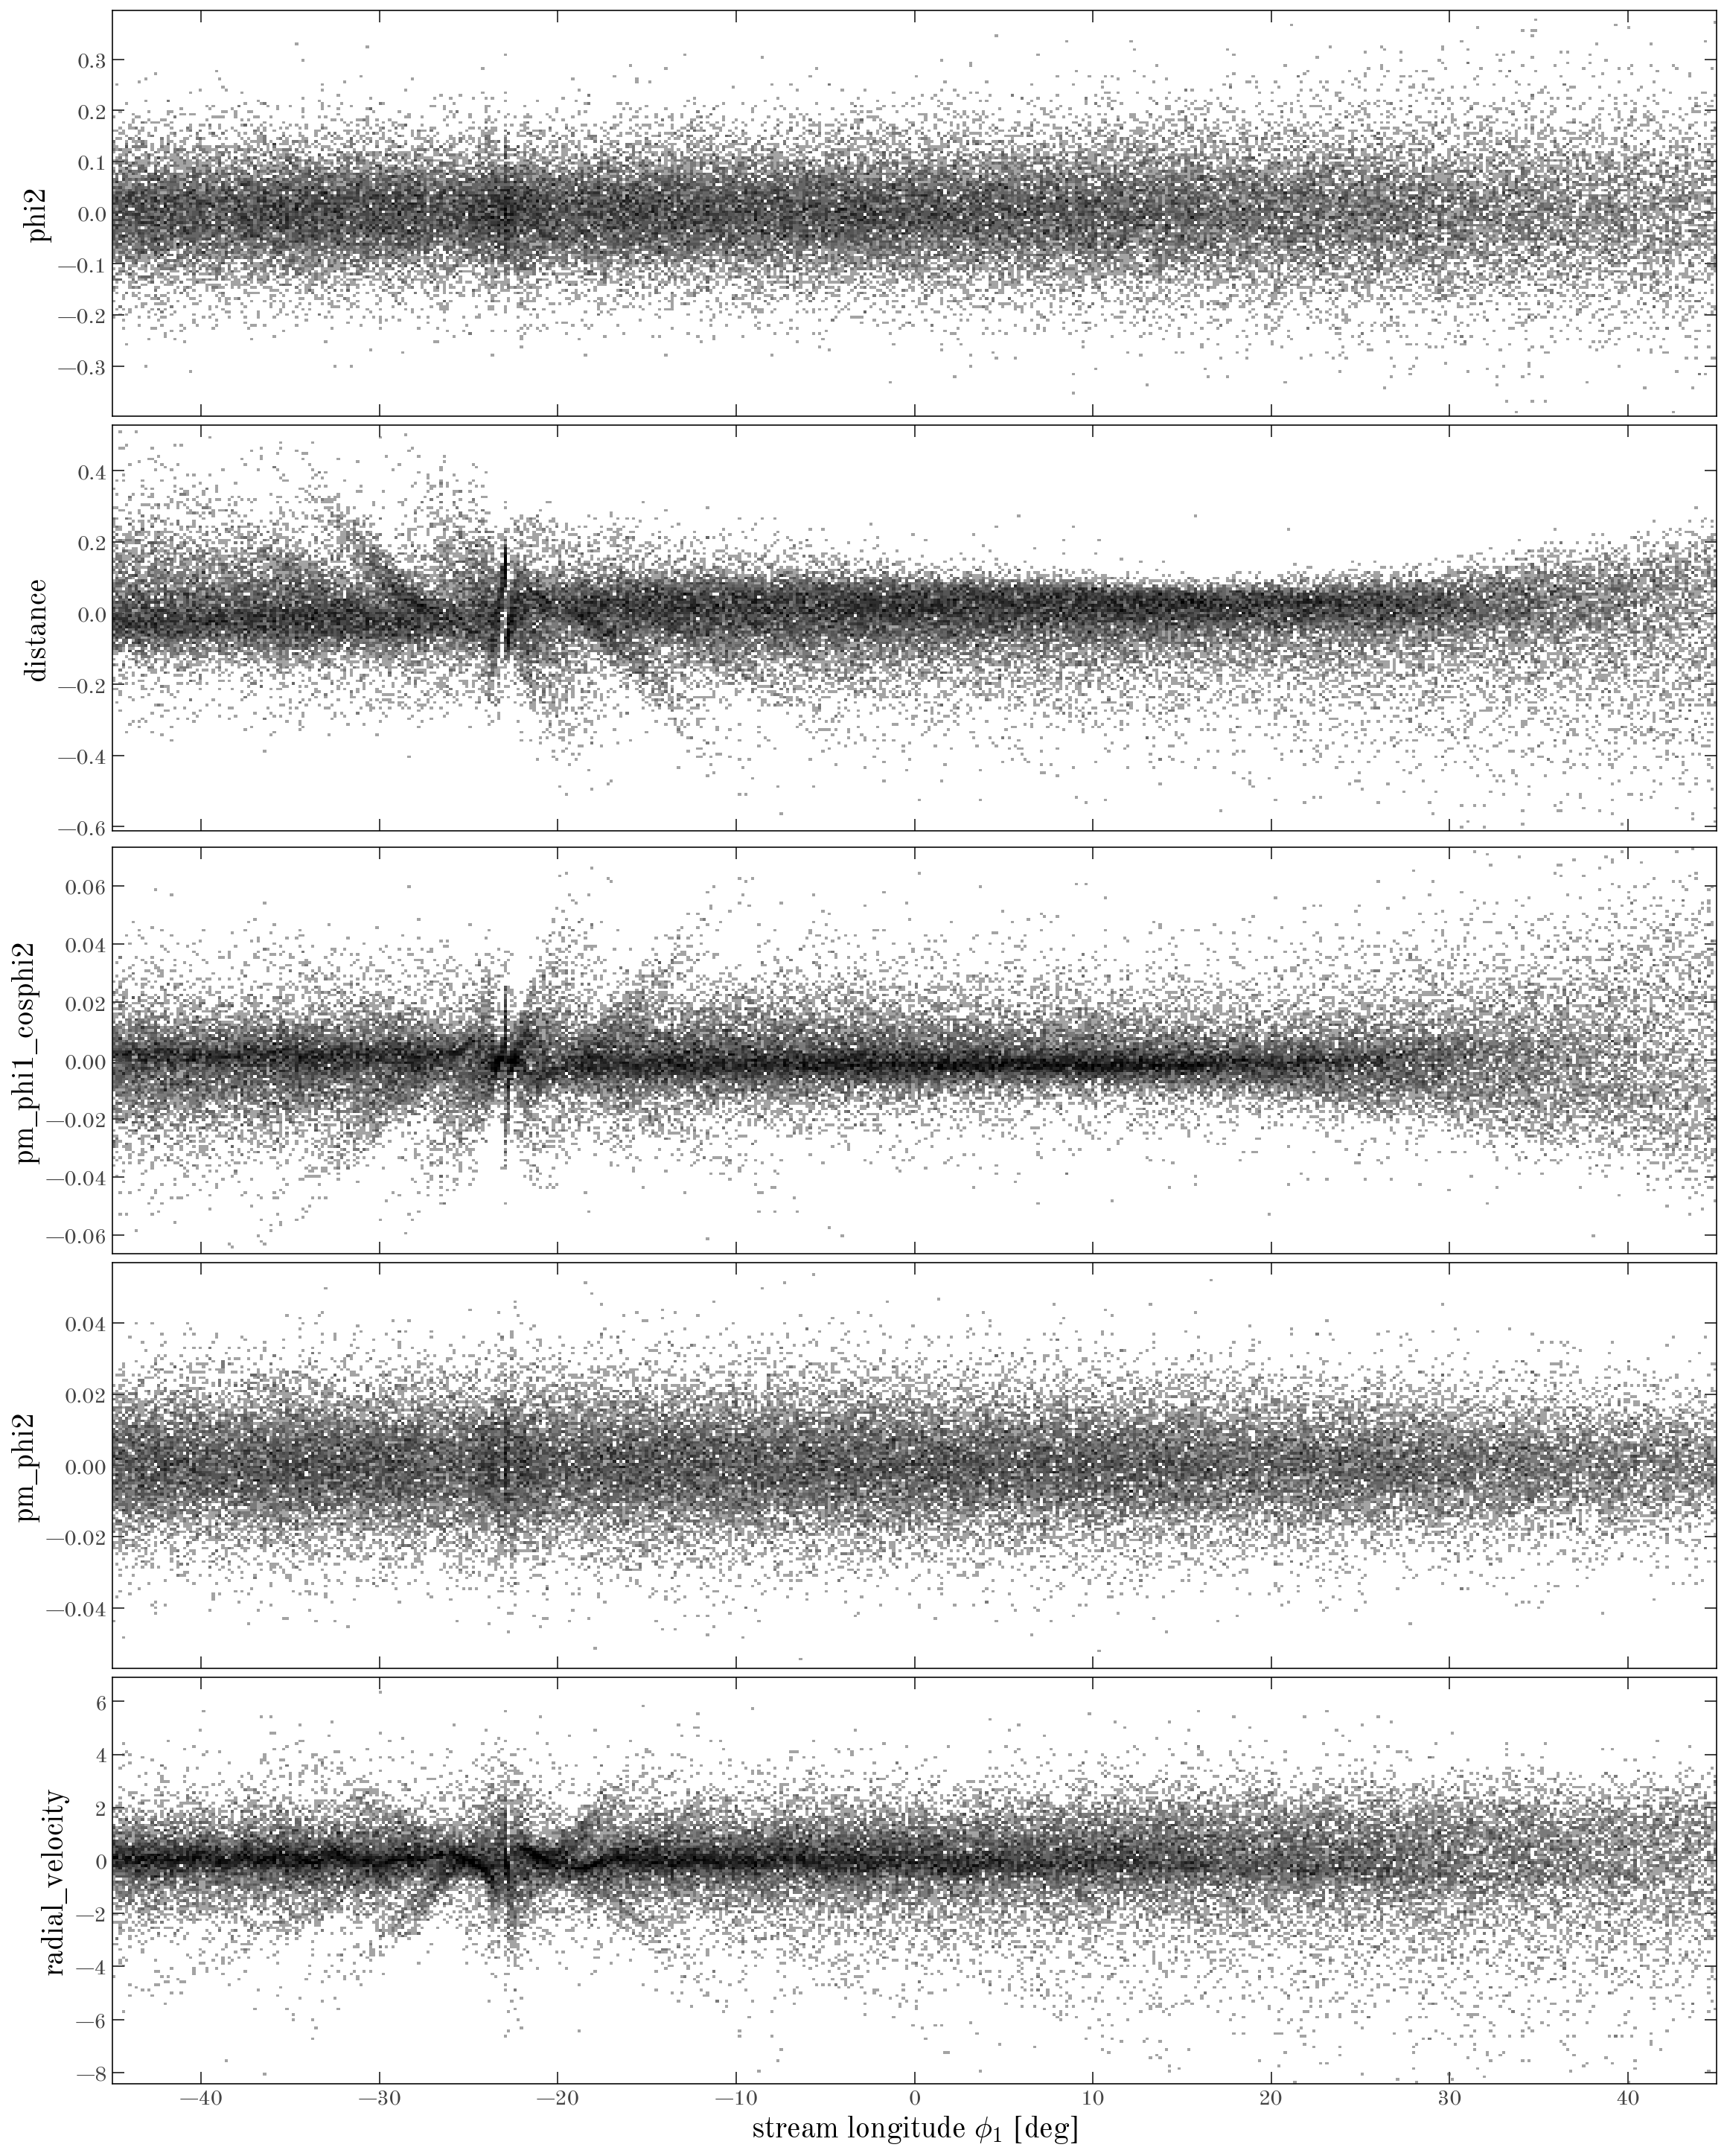

In [29]:
plot_sky_projections(stream_sfr, tracks=tracks);